# WGCNA
weighted gene co-expression network analysis

# Phase 2 vs. Phase 2

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu)

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [18]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 94 samples x 35466 genes

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111133554,LOC111125466,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_B1_O01,7.692872,10.197580,8.354765,7.886383,9.363550,7.548551,7.548551,7.692872,7.548551,7.650623,⋯,18.94773,17.35567,16.72734,16.55278,17.40296,17.50511,15.27334,14.40950,17.08613,13.21049
B1_W5_O50,7.805746,9.653169,8.542687,7.697174,9.355360,7.548551,7.548551,7.845404,7.548551,7.548551,⋯,19.25087,17.60046,17.05547,16.54477,16.97662,17.30129,15.59674,14.95796,17.21506,13.41728
B2_B5_O51,7.871959,9.900281,8.351593,7.548551,9.509373,7.548551,7.548551,8.595408,7.548551,7.651014,⋯,19.41971,17.94342,17.27196,17.23549,17.79404,18.11808,15.98559,15.64247,17.74181,13.77409
B2_C4_O40,7.843091,9.718856,8.513945,7.687586,9.284512,7.548551,7.548551,8.101515,7.843091,7.548551,⋯,18.86611,17.79882,17.27281,16.61824,17.19524,17.19285,15.14694,14.83363,17.01083,13.11047
B3_B4_O41,7.548551,9.612738,8.518601,7.940109,9.198871,7.548551,7.548551,8.014009,7.548551,7.661902,⋯,19.71514,18.17021,17.54836,17.11674,17.49138,17.97654,15.71235,15.28878,17.71717,13.87237
B3_C3_O30,7.909124,9.545333,8.653091,7.989592,9.337765,7.548551,7.710140,8.149132,7.828140,7.926626,⋯,19.27273,17.87689,17.64807,17.08072,17.29751,17.13546,15.58747,15.14063,17.14174,13.28853


[1]    94 35466

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [22]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 70 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


$goodGenes
    [1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
   [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [109]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE
  [145]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [157]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [169]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [181]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [193]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [205]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [217]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [229]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [241]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [253]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [265]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [277]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [289]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [301]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [313]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [325]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [337]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [349]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [361]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE
  [373]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [385]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [397]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [409]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [421]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [433]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [445]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [457]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [469]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [481]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [493]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [505]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [517]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [529]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [541]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [553]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [565]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [577]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [589]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  

[1]    94 35396

### C. Sample size and gene filtering

removing low-variance genes first:

In [24]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 94 samples x 19910 genes

[1]    94 19910

### D. Sample outlier detection

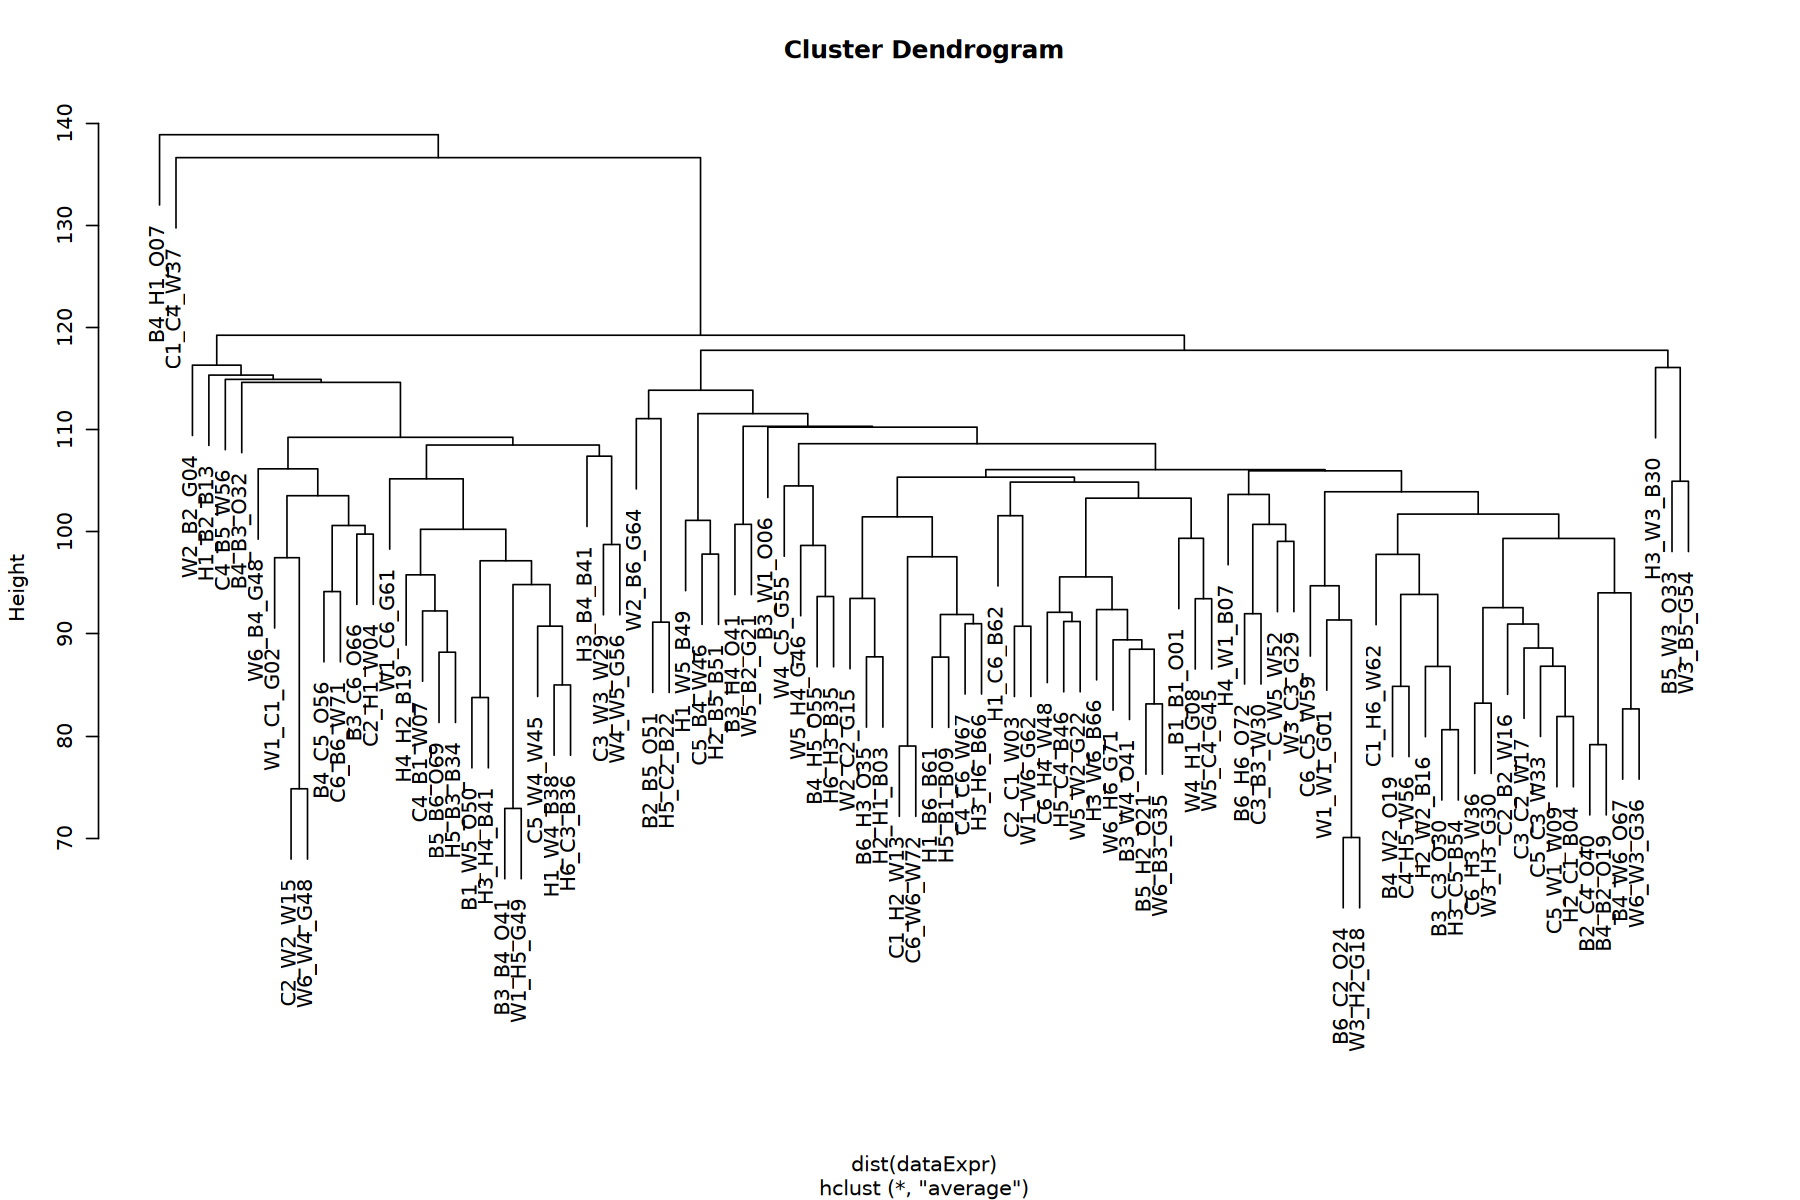

In [28]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outliers - B4_H1_O07 and C1_C4_W37 - becuase they cluster above the rest of the tree and are separated from the main cluster - going to remove those from analysis

In [31]:
dataExpr <- dataExpr[!rownames(dataExpr) %in% c("B4_H1_O07", "C1_C4_W37"), ]
dim(dataExpr) # 92 samples x 19910 genes

[1]    92 19910

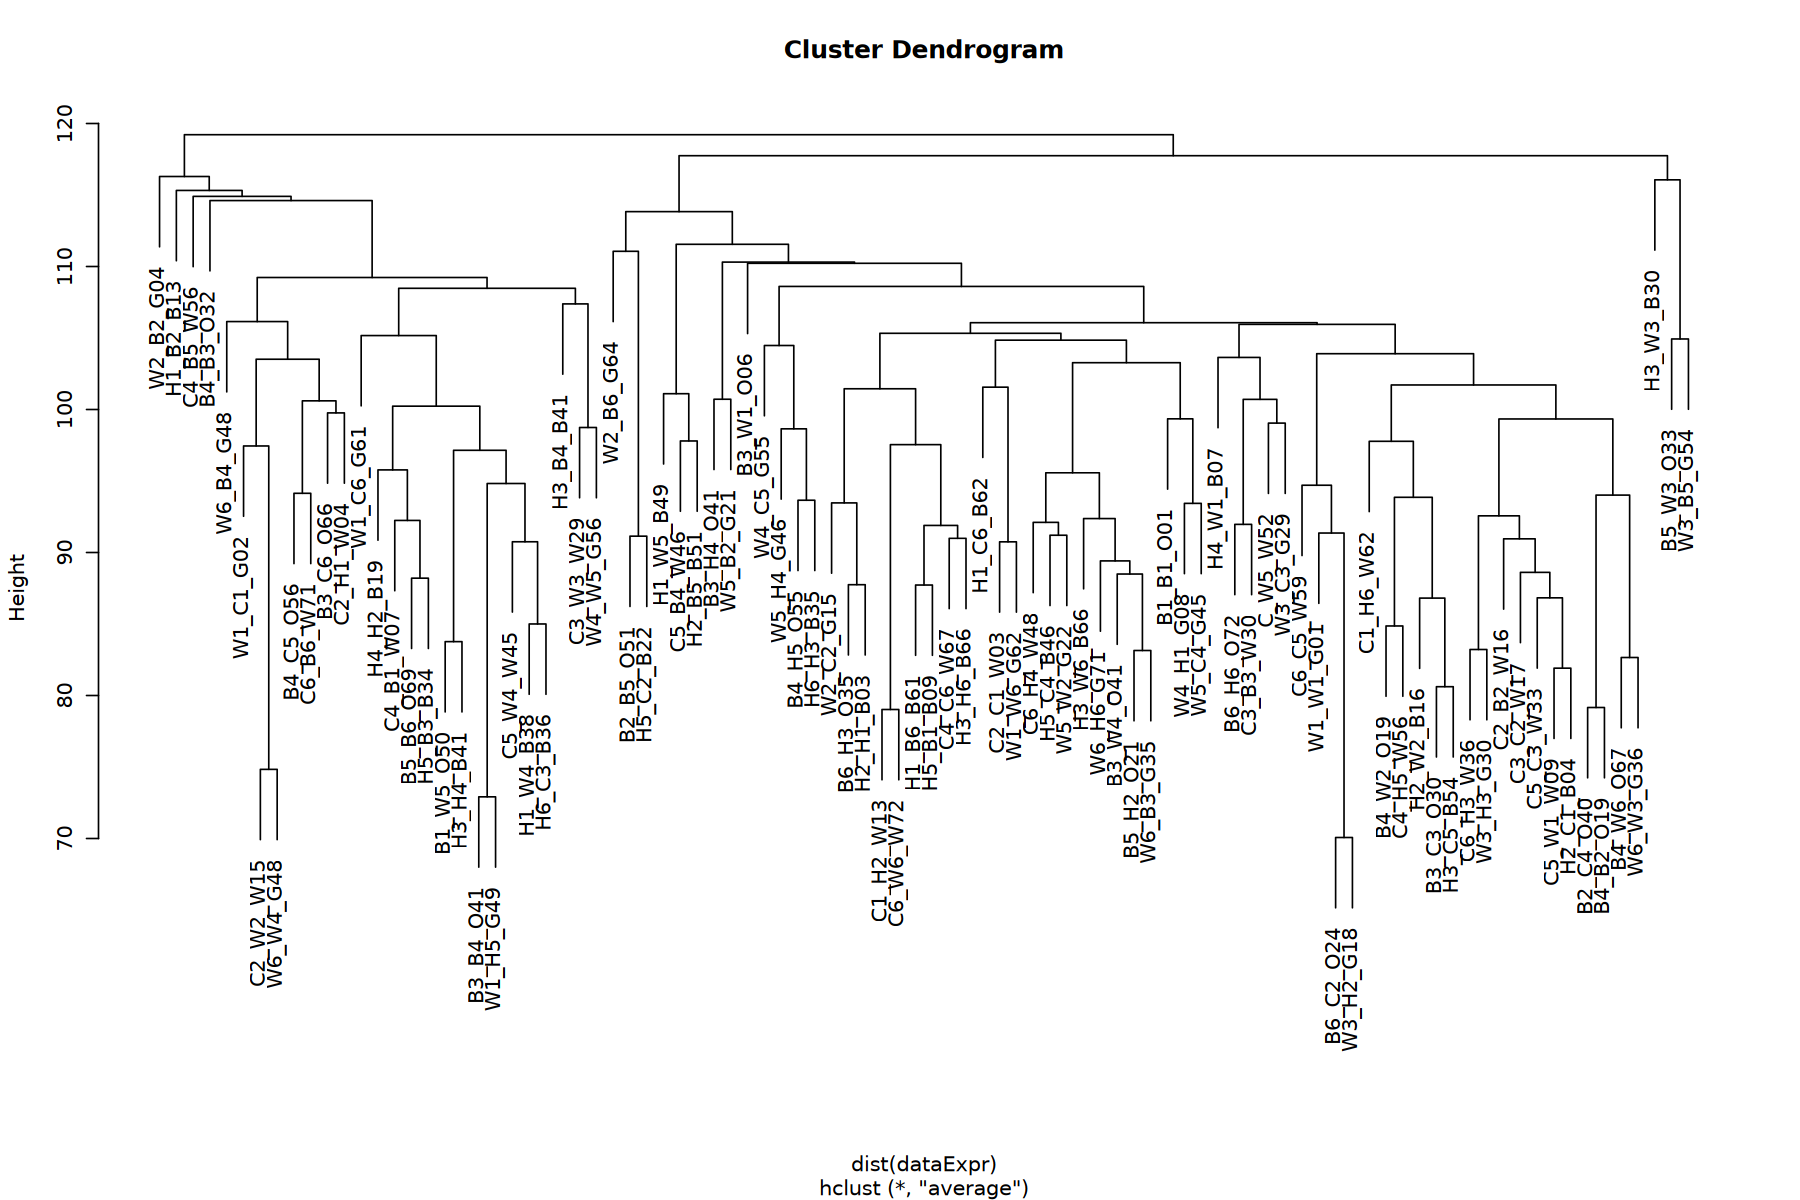

In [36]:
# replot without outliers
sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

looks much better!

### meta data
could add phenotypic data to this ...

In [32]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3


[1] 92  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [33]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both both
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm


,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
W6_W3_G36,warm,warm,normoxic,6,warm,warm,normoxic,3,warm warm
W6_W4_G48,warm,warm,normoxic,6,warm,warm,normoxic,4,warm warm


In [35]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA
start with simple, can progress to consensus if deemed necessary

In [39]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)

In [41]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 2247.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2247 of 19910
   ..working on genes 2248 through 4494 of 19910
   ..working on genes 4495 through 6741 of 19910
   ..working on genes 6742 through 8988 of 19910
   ..working on genes 8989 through 11235 of 19910
   ..working on genes 11236 through 13482 of 19910
   ..working on genes 13483 through 15729 of 19910
   ..working on genes 15730 through 17976 of 19910
   ..working on genes 17977 through 19910 of 19910
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0558 -19.50          0.915 9990.00  9970.000  10400
2      2   0.1940 -14.90          0.746 5120.00  5090.000   5640
3      3   0.5590 -12.50          0.694 2680.00  2640.000   3240
4      4   0.8230  -9.41          0.793 1430.00  1400.000   1980
5      5   0.9230  -7.06          0.901  783.00   751.000   1310
6      6   0.9520  -5.33          0.957  439.00   410

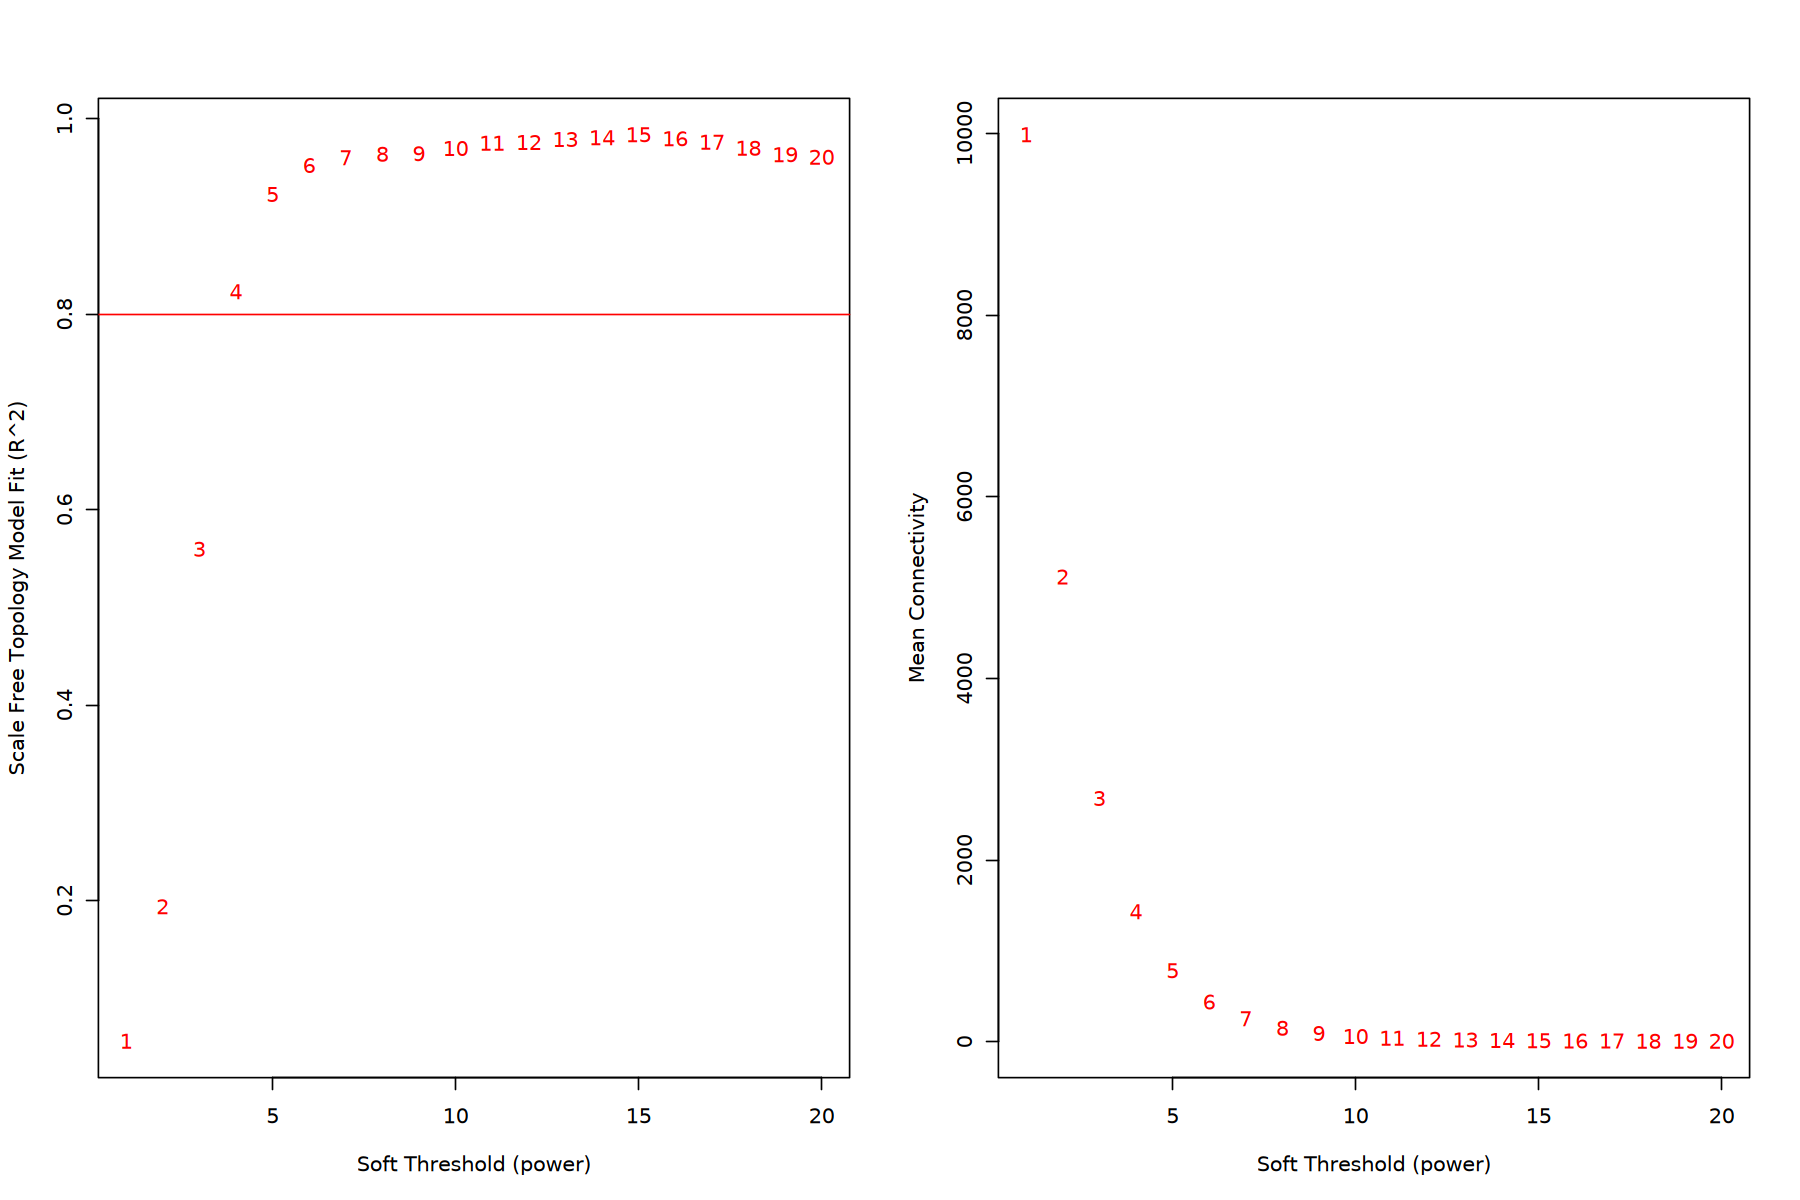

In [42]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 4 is just above 0.8 and anything after 6 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 5 should be appropriate

In [43]:
softPower <- 5

### B. build the network

In [44]:
net <- blockwiseModules(
  dataExpr,
  power = 5,
  networkType = "signed",
  TOMType = "signed",
  minModuleSize = 30,
  mergeCutHeight = 0.25,
  numericLabels = TRUE,
  pamRespectsDendro = FALSE,
  verbose = 3
)


 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4    5 
4949 4509 4075 3295 3082 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 23 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 920 genes from module 1 because their KME is too low.
     ..removing 537 genes from module 2 because their KME is too low.
     ..removing 378 genes from module 3 because their KME is too low.
     ..removing 18 genes from module 4 because their KME is too low.
     ..removing 4 genes from module 5 

In [49]:
# extract module colors
moduleColors <- labels2colors(net$colors)
table(moduleColors)


moduleColors
        black          blue         brown          cyan     darkgreen 
          674          1208           847           220            60 
     darkgrey       darkred darkturquoise         green   greenyellow 
           52            78            55           698           561 
         grey        grey60     lightcyan    lightgreen   lightyellow 
         8891           186           210           123            99 
      magenta  midnightblue          pink        purple           red 
          647           213           650           622           696 
    royalblue        salmon           tan     turquoise        yellow 
           83           328           452          1427           830 

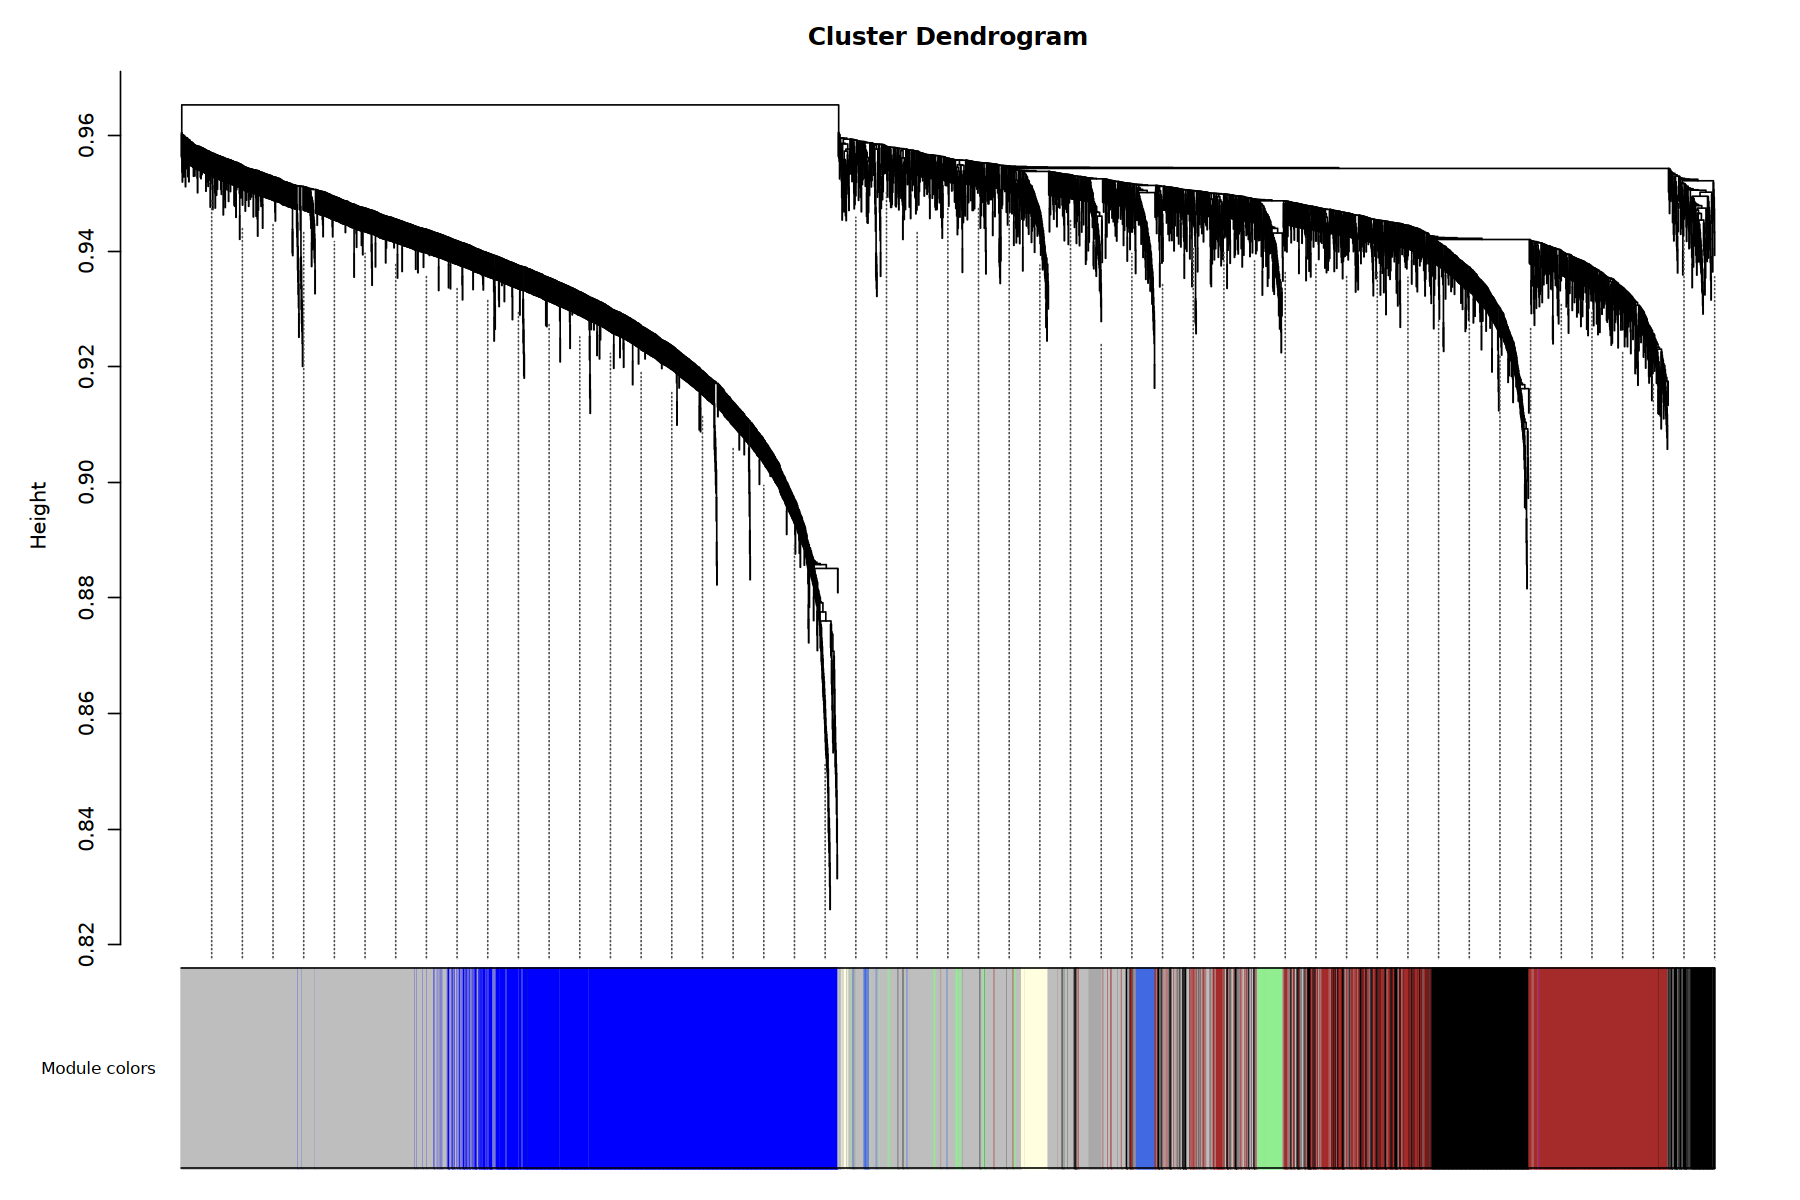

In [50]:
# visualize modules
plotDendroAndColors(
  net$dendrograms[[1]],
  moduleColors[net$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05
)


(how to read these:
- each leaf is a gene, genes are clustered by by topological overlap (TOM)
- height ≈ 1 − TOM similarity (lower merge height = more similar genes)
- each color block = one co-expression module
- grey = genes not assigned to module
- long, continuous blocks = stable modules
- thin blocks = small modules or borderline genes
)

based on plot:
- large blue module and large red/brown module - and leaves look like they match up to these